# ASSIGNMENT WEEK 2: Light Curves Plots of Two Transiting Exoplanets 

Two exoplanets that were detected by TESS were selected from the Exo.mast database and for each of them a Bokeh Phased Light Curve was obtained through python.

Morover the astroquery python catalogue was used for each planet to create a cutout of TESS FFI (full frame images). 

The data was retrieved from the NExScI catalogue.


In [0]:
!pip install astroquery
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits

%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

# Planet 1: TOI-270 b


*Query Planet Table:*

The following query receives an an input the planet name, in this case TOI-270 b, and outputs a json file, associated with a python dictionary.

From this json its is possible to print the properties of the planet.


In [0]:
planet_name = "TOI-270 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


In [0]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'TOI 270 b',
 'dec': -51.956233,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 68.4155,
 'starName': 'TOI 270',
 'tessID': 259377017,
 'tessTCE': 'TCE_2'}

*Get Planet Properties:*

Planet properties are extracted for the Planet in consideration. Two composite tables from separate sources could be used, but in this case only the NExScI source has information about the exoplanet.

In [0]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()
print(len(planet_prop))
print("Catalog 1: " + planet_prop[0]['catalog_name'])
#print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()

1
Catalog 1: nexsci


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

In [0]:
print("DS Tuc A b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

DS Tuc A b Properties
Stellar Mass 0.400000 M_sun
Planet Mass 0.006570 M_Jupiter
Planet Mass Reference: Calculated Value


*Get TCE Data and Header for TOI-270 b*

Through the Transit Planet Search module, TESS tries to find transit signals. If, during this search, the detected signal is bigger/smaller than an associated noise, a TCE (Threshold Crossing Event) is created. TCEs are usually detected because of an exoplanet orbiting in front of the star. This following code retrieves the header information of the exoplanet and also detects the TESS sector where the data is located.


In [0]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors

['s0004-s0004', 's0003-s0003', 's0005-s0005', 's0001-s0006']

In [0]:
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 259377017
Planet Radius: 1.486570


*Plot the light curve data:*

The following algorythm outputs different light curves, including the median detrended curve (LC_DETREND), the initial light curve (LC_INIT) used for the treshold crossing event (LC_INIT), and the curve of the transit model (MODEL_INIT).


In [0]:
# Get The data
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

In [0]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Text(0, 0.5, 'Relative Flux')

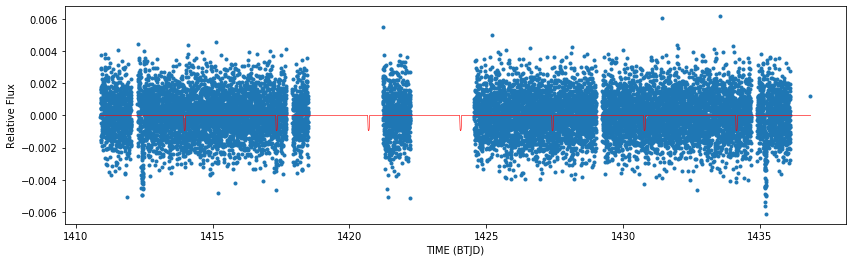

In [0]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

*Request a Bokeh Phased Light Curve*

The previous plot will be folded by the following API, in such a way that it will presents only one period of the recognized TCE.

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

In [0]:
display(HTML(str(r.content.decode('utf-8'))))

*Get Coordinates of the Target Using Astroquery Catalogs*

For a given TIC identity, a planet is searched along with the nearby stars (cone search). A table that includes the found objects is outputted. The desired star is confirmed by specific, printed TIC quantities.

In [0]:
ticid = 259377017

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
259377017 10.4981  9.099 68.4155009405299 -51.9562322933249    STAR
685369655 19.5201    nan 68.4233408498536 -51.9584850137924    STAR
685369843 19.0174    nan 68.4076845395286 -51.9494741561534    STAR
259377022 17.5689 16.396 68.4211716454316  -51.965438802293    STAR
685369845 18.3343    nan 68.3989524956428 -51.9493055094822    STAR


In [0]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)
print(nearbyStars)

[[68.4155009405299, -51.9562322933249], [68.4380306959212, -51.9505805323226], [68.4391119781766, -51.9661439460019], [68.4011249778552, -51.9793634819794], [68.4104496461244, -51.9832271565681], [68.400288819774, -51.9831216726462], [68.4626579491954, -51.9472172883613], [68.4550931229215, -51.9928022316233], [68.3555495520045, -51.9981766471834], [68.460018643547, -51.9015361270852], [68.3160633514994, -51.9754665713466], [68.5017737824428, -51.91858790679]]


*Query Which Sectors are Available*

The following API prints which sector, camera and CCD is storing the data for the star that we are looking for.

In [0]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0003-3-4      3      3   4
tess-s0004-3-4      4      3   4
tess-s0005-3-3      5      3   3


*Request pixel timeseries cutout from TESS FFIs*

The following API will run a cutout around the requested Right Ascension and Declination parameters.

Units of distances are expressed in pixels.

In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)

In [0]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1288R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


3

In [0]:
#hdulist[1].info()

*Plot the First Image of the Time Series*

The following algorythm will visualize some information of the previously done cutout. The output will be the first image of the time series.

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

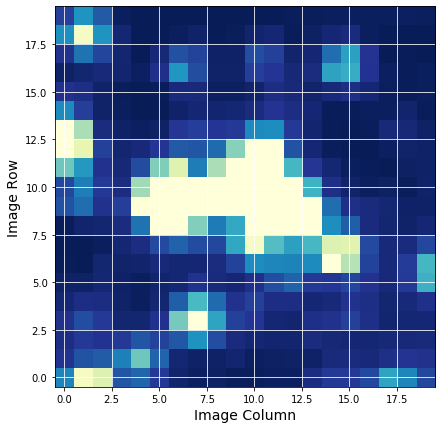

In [0]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

*Show the first image of the second file*

From the previous picture, a World Coordinate System (WCS) is added in the following algorythm in order to mark both the exoplanet star (red dot) and the other stars in the cone search (orange dots).

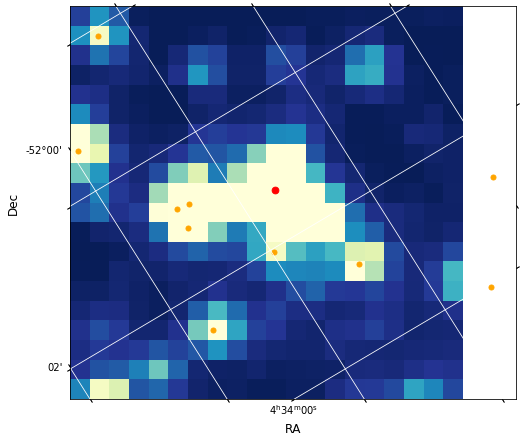

In [0]:
hdu2 = hdulist[0]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

# Planet 2: DS Tuc A b


*Query Planet Table:*

The following query receives an an input the planet name, in this case DS Tuc A b, and outputs a json file, associated with a python dictionary.

From this json its is possible to print the properties of the planet.

In [0]:
planet_name = "DS Tuc A b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))


application/json; charset=UTF-8


In [0]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names


{'canonicalName': 'DS Tuc A b',
 'dec': -69.195747,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 354.91449,
 'starName': 'DS Tuc A',
 'tessID': 410214986,
 'tessTCE': 'TCE_1'}

*Get Planet Properties:*

Planet properties are extracted for the Planet in consideration. Two composite tables from separate sources could be used, but in this case only the NExScI source has information about the exoplanet.

In [0]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()
print(len(planet_prop))
print("Catalog 1: " + planet_prop[0]['catalog_name'])
#print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()


1
Catalog 1: nexsci


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

In [0]:
print("DS Tuc A b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))


DS Tuc A b Properties
Stellar Mass 1.010000 M_sun
Planet Mass 1.300000 M_Jupiter
Planet Mass Reference: Benatti et al. 2019


*Get TCE Data and Header for DS Tuc A b*

Through the Transit Planet Search module, TESS tries to find transit signals. If, during this search, the detected signal is bigger/smaller than an associated noise, a TCE (Threshold Crossing Event) is created. TCEs are usually detected because of an exoplanet orbiting in front of the star. This following code retrieves the header information of the exoplanet and also detects the TESS sector where the data is located.


In [0]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors


['s0001-s0001']

In [0]:
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])


TIC: TIC 410214986
Planet Radius: 8.254507


*Plot the light curve data:*

The following algorythm outputs different light curves, including the median detrended curve (LC_DETREND), the initial light curve (LC_INIT) used for the treshold crossing event (LC_INIT), and the curve of the transit model (MODEL_INIT).


In [0]:
# Get The data
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()


In [0]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Text(0, 0.5, 'Relative Flux')

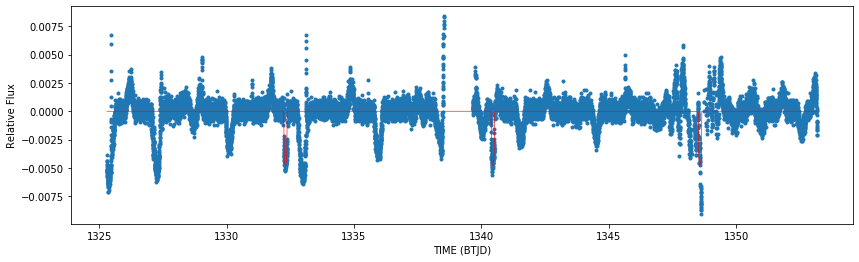

In [0]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

*Request a Bokeh Phased Light Curve*

The previous plot will be folded by the following API, in such a way that it will presents only one period of the recognized TCE.


In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)


In [0]:
display(HTML(str(r.content.decode('utf-8'))))

*Get Coordinates of the Target Using Astroquery Catalogs*

For a given TIC identity, a planet is searched along with the nearby stars (cone search). A table that includes the found objects is outputted. The desired star is confirmed by specific, printed TIC quantities.

In [0]:
ticid = 410214986

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )


    ID       Tmag   Jmag        ra               dec        objType
---------- ------- ----- ---------------- ----------------- -------
 410214986  7.8541 7.122 354.914504004534  -69.195752595235    STAR
 410214984  8.7568  7.63 354.913624788909 -69.1943041563466    STAR
2054837507 18.6234   nan 354.911785410185 -69.1981581230906    STAR
2054837508 19.4619   nan 354.893602966012 -69.1944933347191    STAR
2054837500  18.515   nan  354.94348226655 -69.2012018840914    STAR


In [0]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)
print(nearbyStars)


[[354.914504004534, -69.195752595235], [354.913624788909, -69.1943041563466], [354.846172327765, -69.2205382457277], [354.883882668105, -69.1613044343683], [354.898149506018, -69.2351140249952], [354.790657236588, -69.1835979879649], [355.058095644241, -69.1946868574641]]


*Query Which Sectors are Available*

The following API prints which sector, camera and CCD is storing the data for the star that we are looking for.


In [0]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-2      1      3   2


*Request pixel timeseries cutout from TESS FFIs*

The following API will run a cutout around the requested Right Ascension and Declination parameters.

Units of distances are expressed in pixels.

In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)

In [0]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

In [0]:
#hdulist[1].info()

*Plot the First Image of the Time Series*

The following algorythm will visualize some information of the previously done cutout. The output will be the first image of the time series.

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

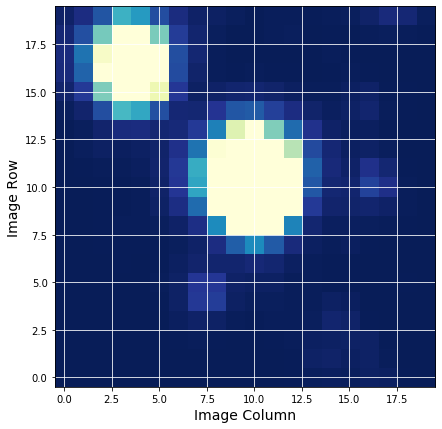

In [0]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

*Show the first image of the second file*

From the previous picture, a World Coordinate System (WCS) is added in the following algorythm in order to mark both the exoplanet star (red dot) and the other stars in the cone search (orange dots).

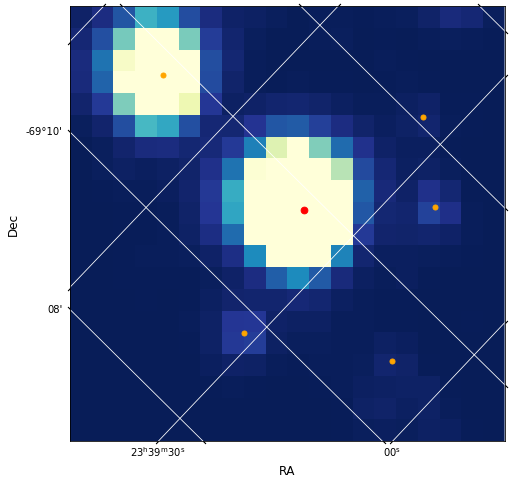

In [0]:
hdu2 = hdulist[0]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

*Restrict the visualized data frame to a desired range*

From the website https://tess.mit.edu/observations/ it it possible to recover the dates in which the sectors in considerations were examined. The dates would then be converted to the Barycentric Julian Date (BJD) system via an online converter, and finally the number 2457000 has to be subtracted in orter to adjust to TESS.

1352.5
1381.5
(20076, 15)
(490, 15)


Text(0, 0.5, 'Relative Flux')

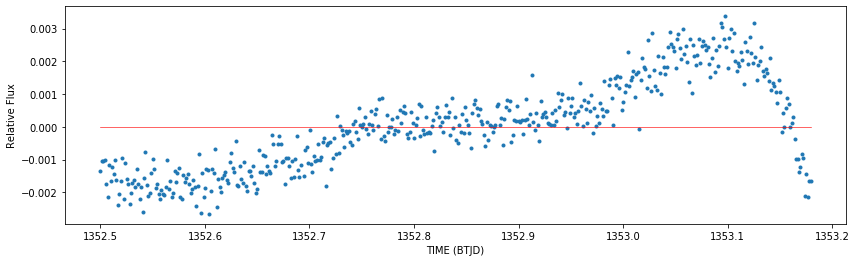

In [0]:
start_date = 2458352.5
end_date = 2458381.5


start_date = start_date - 2457000
end_date = end_date - 2457000
print(start_date)
print(end_date)
print(data.shape)



#print(type(data))
restricted_data = data.loc[data['TIME']>=start_date]
restricted_data = restricted_data.loc[restricted_data['TIME']<=end_date]
detrend = restricted_data['LC_DETREND']
model = restricted_data['MODEL_INIT']
time = restricted_data['TIME']
print(restricted_data.shape)
plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')